## The goal of this analysis is to help the business to answer the question 
    1. Should the software sold for $39 or $59
    2. What drives the conversion rate, especially in user behavior?
    3. Does the experiment run too long?

## Analysis Agenda
    1. Load Data + Overview Datasets
    2. Analysis results of A/B Test
    3. Sanity check of A/B Test
    4. Machine Learning -- Feature analysis

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import auc, roc_curve, classification_report


# 1. Load Data + Check Datasets if they are "clean"

In [214]:
def check_data(df):
    '''
    this function examine the loaded data
    '''
    # examine the data
    print('The head of the data: ')
    print(df.head())
    print('The tail of the data: ')
    print(df.tail())
    # examine how many data points and columns in the dataset
    print('There are %d rows and %d columns.'%(df.shape[0], df.shape[1]))
    print('Data types and number of data points in the dataset: ')
    print(df.info())
    print('The number of duplicated user_id in the dataset: ', sum(df.duplicated('user_id')))

In [215]:
##### df_test table
df_test = pd.read_csv('test_results.csv')
check_data(df_test)

The head of the data: 
   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted  
0     0     39          0  
1     0     39          0  
2     0     39          0  
3     1     59          0  
4     0     39          0  
The tail of the data: 
        user_id            timestamp           source  device  \
316795    17427  2015-04-11 09:29:15     ads_facebook     web   
316796   687787  2015-03-16 23:31:55   direct_traffic     web   
316797   618863  2015-04-11 01:35:19       ads-google     web   
316798   154636  2015-05-14 05:46:42  friend_referral  mobile   
3167

In [216]:
## date changes from object to datetime format for future analysis need
#df_test['timestamp'] = df_test['timestamp'].astype('datetime64[ns]')
## user_id changes from int to string
df_test['user_id'] = df_test['user_id'].apply(str)

In [217]:
##### df_user table
df_user = pd.read_csv('user_table.csv')
check_data(df_user)

The head of the data: 
   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68
The tail of the data: 
        user_id         city country    lat    long
275611   485975      Atlanta     USA  33.76  -84.42
275612    35479  Los Angeles     USA  34.11 -118.41
275613   516519      Chicago     USA  41.84  -87.68
275614   984877        Tampa     USA  27.96  -82.48
275615   232078  Springfield     USA  44.05 -122.98
There are 275616 rows and 5 columns.
Data types and number of data points in the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-n

In [218]:
#df_test['timestamp'] = df_test['timestamp'].astype('datetime64[ns]')
## user_id changes from int to string
df_user['user_id'] = df_user['user_id'].apply(str)

# 2. Data Explore

In [219]:
#merge data
df_merge = df_test.merge(df_user,on='user_id',how='left')

In [220]:
check_data(df_merge)
print(" ")
print("check if left join doesn't create more rows")
print(df_test.shape[0] == df_merge.shape[0])

The head of the data: 
  user_id            timestamp          source  device operative_system  test  \
0  604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS     0   
1  624057  2015-05-10 21:08:46      seo-google  mobile          android     0   
2  317970  2015-04-04 15:01:23        ads-bing  mobile          android     0   
3  685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS     1   
4  820854  2015-05-24 11:04:40    ads_facebook     web              mac     0   

   price  converted          city country    lat   long  
0     39          0       Buffalo     USA  42.89 -78.86  
1     39          0     Lakeville     USA  44.68 -93.24  
2     39          0         Parma     USA  41.38 -81.73  
3     59          0  Fayetteville     USA  35.07 -78.90  
4     39          0       Fishers     USA  39.95 -86.02  
The tail of the data: 
       user_id            timestamp           source  device operative_system  \
316795   17427  2015-04-11 09:29:15   

<font color='blue'>**we see NA in column city, country, lat, and long, which means that there are users in df_test but not in df_user.**

## 2.1 Time

In [222]:
df_merge.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,hour
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,3
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,21
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,15
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,7
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,11


In [225]:
### create variables of time
df_merge['timestamp_date'] =  df_merge['timestamp'].str[:10].astype('datetime64[ns]')  ## get date
df_merge['hour'] = df_merge['timestamp'].str[11:13].str.strip("0")  ## get hour in a day
df_merge['month'] = df_merge['timestamp_date'].dt.month ## get month in a year
df_merge['date_of_month'] =  df_merge['timestamp_date'].dt.day ## get date in a month

### 2.1.1 Date

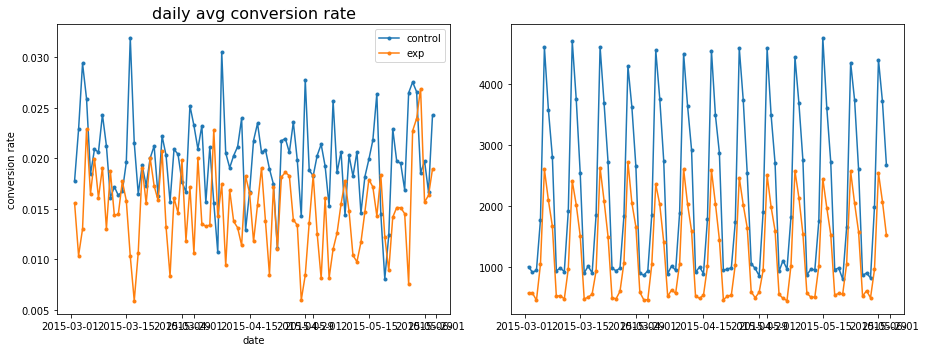

In [226]:

ctrol_daily_cr = df_merge[df_merge['test'] == 0][['timestamp_date','converted']].groupby('timestamp_date').mean().reset_index()
exp_daily_cr = df_merge[df_merge['test'] == 1][['timestamp_date','converted']].groupby('timestamp_date').mean().reset_index()

ctrol_daily_count = df_merge[df_merge['test'] == 0][['timestamp_date','converted']].groupby('timestamp_date').count().reset_index()
exp_daily_count = df_merge[df_merge['test'] == 1][['timestamp_date','converted']].groupby('timestamp_date').count().reset_index()

## time
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(13, 5))
ax[0].plot(ctrol_daily_cr['timestamp_date'],ctrol_daily_cr['converted'],'.-',label = 'control')
ax[0].plot(exp_daily_cr['timestamp_date'],exp_daily_cr['converted'],'.-',label = 'exp')

ax[0].set_title('daily avg conversion rate',fontsize = 16)
ax[0].set_xlabel('date')
ax[0].set_ylabel('conversion rate')
ax[0].legend()

ax[1].plot(ctrol_daily_count['timestamp_date'],ctrol_daily_count['converted'],'.-',label = 'control')
ax[1].plot(exp_daily_count['timestamp_date'],exp_daily_count['converted'],'.-',label = 'exp')

plt.tight_layout()
plt.show()


### 2.1.2 Month

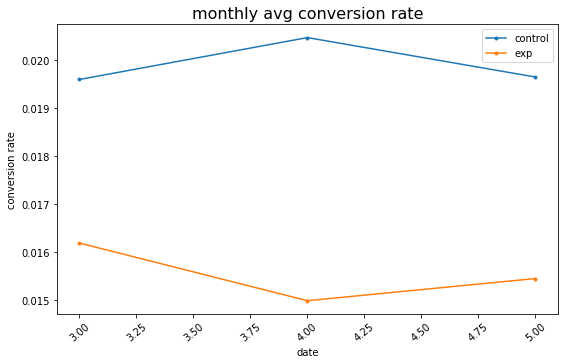

In [227]:
ctrol_daily_cr = df_merge[df_merge['test'] == 0][['month','converted']].groupby('month').mean().reset_index()
exp_daily_cr = df_merge[df_merge['test'] == 1][['month','converted']].groupby('month').mean().reset_index()
## time
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ctrol_daily_cr['month'],ctrol_daily_cr['converted'],'.-',label = 'control')
ax.plot(exp_daily_cr['month'],exp_daily_cr['converted'],'.-',label = 'exp')

ax.set_title('monthly avg conversion rate',fontsize = 16)
ax.set_xlabel('date')
ax.set_ylabel('conversion rate')
ax.legend()
plt.tight_layout()
plt.xticks(rotation=40)
plt.show()


### 2.1.3 Date of Week

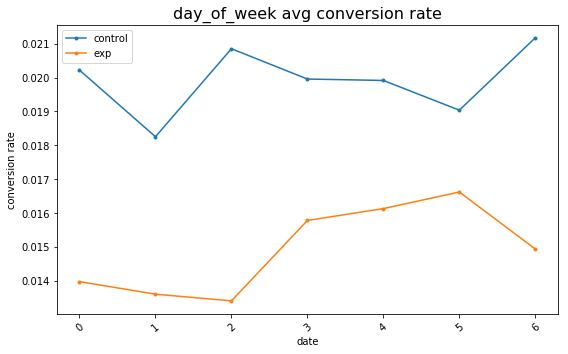

In [228]:
df_merge['week_day'] =  df_merge['timestamp_date'].dt.dayofweek
ctrol_daily_cr = df_merge[df_merge['test'] == 0][['week_day','converted']].groupby('week_day').mean().reset_index()
exp_daily_cr = df_merge[df_merge['test'] == 1][['week_day','converted']].groupby('week_day').mean().reset_index()
## time
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ctrol_daily_cr['week_day'],ctrol_daily_cr['converted'],'.-',label = 'control')
ax.plot(exp_daily_cr['week_day'],exp_daily_cr['converted'],'.-',label = 'exp')

ax.set_title('day_of_week avg conversion rate',fontsize = 16)
ax.set_xlabel('date')
ax.set_ylabel('conversion rate')
ax.legend()
plt.tight_layout()
plt.xticks(rotation=40)
plt.show()

### 2.1.4 Date of a Month

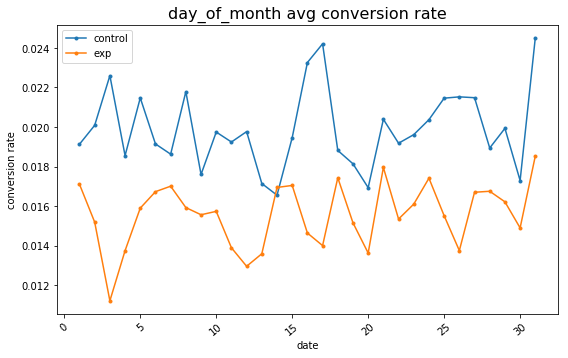

In [229]:
ctrol_daily_cr = df_merge[df_merge['test'] == 0][['date_of_month','converted']].groupby('date_of_month').mean().reset_index()
exp_daily_cr = df_merge[df_merge['test'] == 1][['date_of_month','converted']].groupby('date_of_month').mean().reset_index()
## time
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ctrol_daily_cr['date_of_month'],ctrol_daily_cr['converted'],'.-',label = 'control')
ax.plot(exp_daily_cr['date_of_month'],exp_daily_cr['converted'],'.-',label = 'exp')

ax.set_title('day_of_month avg conversion rate',fontsize = 16)
ax.set_xlabel('date')
ax.set_ylabel('conversion rate')
ax.legend()
plt.tight_layout()
plt.xticks(rotation=40)
plt.show()

## 2.2 Source

In [230]:
def conversion_rate_breakdown_bytestctrol(df):
    df_mean = df.groupby(df.columns.tolist()[0:2]).mean().reset_index().rename(columns={"converted": "conversion_rate_mean"})
    df_count = df.groupby(df.columns.tolist()[0:2]).count().reset_index().rename(columns={"converted": "count"})
    df_mean_count = df_mean.merge(df_count,on=df.columns.tolist()[0:2],how='left')
    return df_mean_count

[Text(0.0, 0, 'ads-bing'),
 Text(0.2, 0, 'ads-google'),
 Text(0.4, 0, 'ads-yahoo'),
 Text(0.6000000000000001, 0, 'ads_facebook'),
 Text(0.8, 0, 'ads_other'),
 Text(1.0, 0, 'direct_traffic'),
 Text(0, 0, 'friend_referral'),
 Text(0, 0, 'seo-bing'),
 Text(0, 0, 'seo-google'),
 Text(0, 0, 'seo-other'),
 Text(0, 0, 'seo-yahoo'),
 Text(0, 0, 'seo_facebook')]

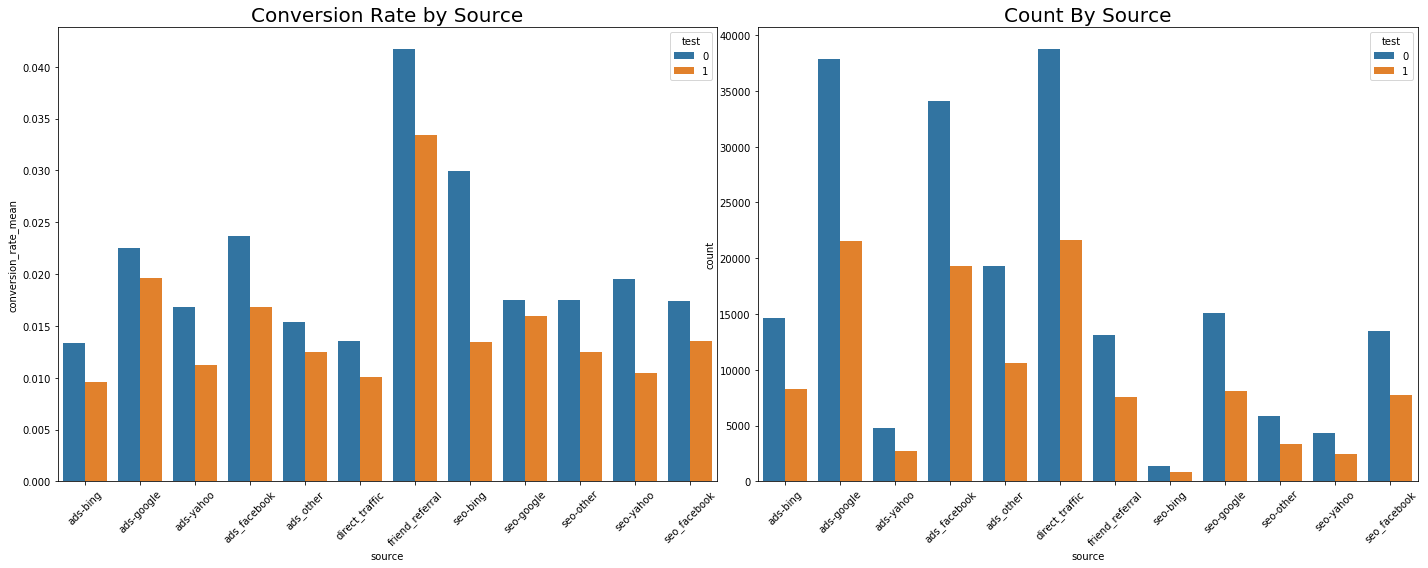

In [246]:
df_breakdown = df_merge[['source','test','converted']]
df_breakdown = conversion_rate_breakdown_bytestctrol(df_breakdown)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.barplot(x='source', y="conversion_rate_mean", hue='test', data=df_breakdown, ax=ax[0])
ax[0].set_title('Conversion Rate by Source', fontsize=20)
#ax[0].set_yscale('log')
#ax[0].set_xticklabels(labels=df_breakdown['source'], rotation=45)
ax[0].set_xticklabels(labels=df_breakdown['source'].unique(), rotation=45)
plt.tight_layout()
############ conversion_rate, which one is higher bt control and exp group. They should follow the same trend

sns.barplot(x='source', y="count", hue='test', data=df_breakdown, ax=ax[1])
ax[1].set_title('Count By Source', fontsize=20)
#ax[1].set_yscale('log')
ax[1].set_xticklabels(labels=df_breakdown['source'].unique(), rotation=45)
######## The percentage of each category should be the same between control and exp group

## 2.3 device

Text(0.5, 1.0, 'Count By device')

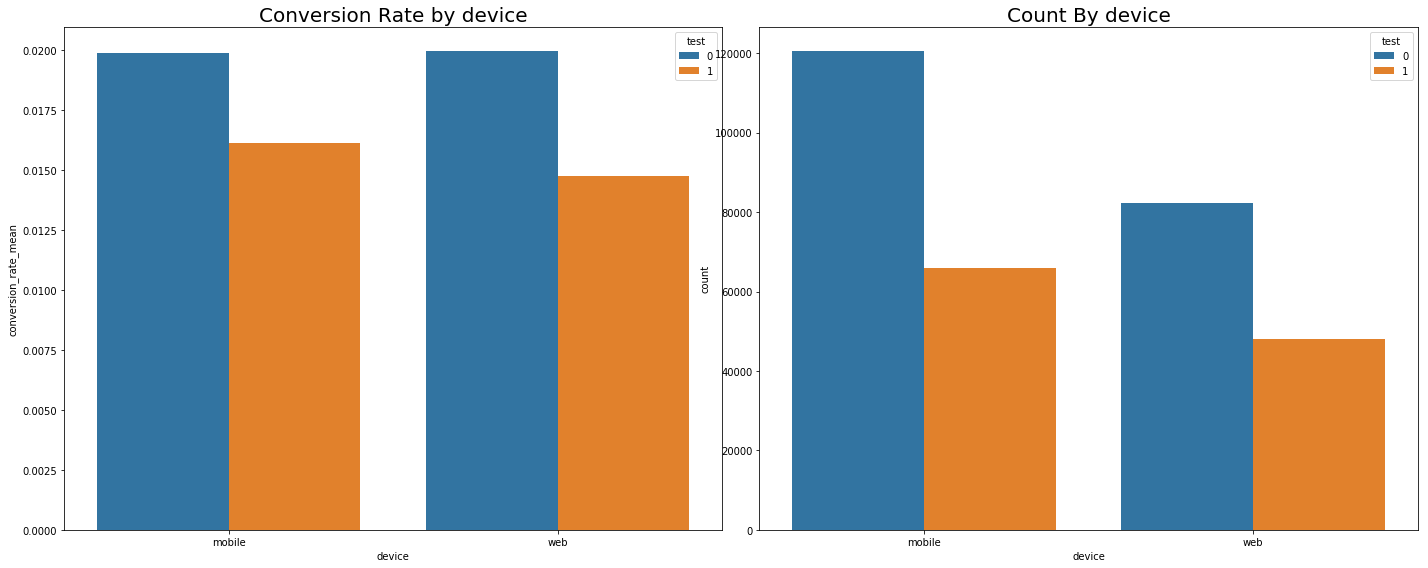

In [232]:
df_breakdown = df_merge[['device','test','converted']]
df_breakdown = conversion_rate_breakdown_bytestctrol(df_breakdown)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.barplot(x='device', y="conversion_rate_mean", hue='test', data=df_breakdown, ax=ax[0])
ax[0].set_title('Conversion Rate by device', fontsize=20)
#ax[0].set_yscale('log')
#ax[0].set_xticklabels(labels=df_breakdown['device'].unique(), rotation=45)
plt.tight_layout()
############ conversion_rate, which one is higher bt control and exp group. They should follow the same trend

sns.barplot(x='device', y="count", hue='test', data=df_breakdown, ax=ax[1])
ax[1].set_title('Count By device', fontsize=20)
#ax[1].set_yscale('log')
#ax[1].set_xticklabels(labels=df_breakdown['device'].unique(), rotation=45)
######## The percentage of each category should be the same between control and exp group

## 2.4 operative_system	

Text(0.5, 1.0, 'Count By operative_system')

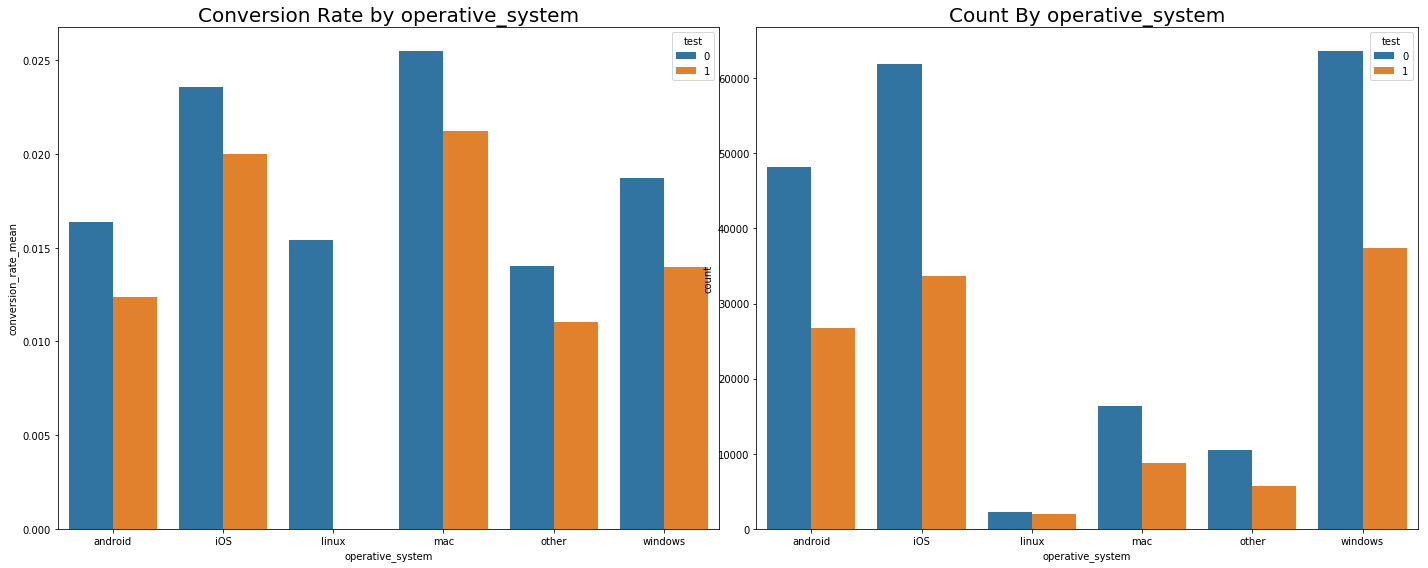

In [233]:
df_breakdown = df_merge[['operative_system','test','converted']]
df_breakdown = conversion_rate_breakdown_bytestctrol(df_breakdown)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.barplot(x='operative_system', y="conversion_rate_mean", hue='test', data=df_breakdown, ax=ax[0])
ax[0].set_title('Conversion Rate by operative_system', fontsize=20)
#ax[0].set_yscale('log')
#ax[0].set_xticklabels(labels=df_breakdown['operative_system'].unique(), rotation=45)
plt.tight_layout()
############ conversion_rate, which one is higher bt control and exp group. They should follow the same trend

sns.barplot(x='operative_system', y="count", hue='test', data=df_breakdown, ax=ax[1])
ax[1].set_title('Count By operative_system', fontsize=20)
#ax[1].set_yscale('log')
#ax[1].set_xticklabels(labels=df_breakdown['operative_system'].unique(), rotation=45)
######## The percentage of each category should be the same between control and exp group

## 2.5 Top city

[Text(0.0, 0, 'Austin'),
 Text(0.2, 0, 'Buffalo'),
 Text(0.4, 0, 'Charlotte'),
 Text(0.6000000000000001, 0, 'Chicago'),
 Text(0.8, 0, 'Dallas'),
 Text(1.0, 0, 'Detroit'),
 Text(0, 0, 'Fort Worth'),
 Text(0, 0, 'Houston'),
 Text(0, 0, 'Indianapolis'),
 Text(0, 0, 'Jacksonville'),
 Text(0, 0, 'Las Vegas'),
 Text(0, 0, 'Los Angeles'),
 Text(0, 0, 'Memphis'),
 Text(0, 0, 'Mesa'),
 Text(0, 0, 'Minneapolis'),
 Text(0, 0, 'Nashville'),
 Text(0, 0, 'New Orleans'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oakland'),
 Text(0, 0, 'Oklahoma City'),
 Text(0, 0, 'Philadelphia'),
 Text(0, 0, 'Plano'),
 Text(0, 0, 'Raleigh'),
 Text(0, 0, 'San Antonio'),
 Text(0, 0, 'San Jose'),
 Text(0, 0, 'Seattle'),
 Text(0, 0, 'Springfield'),
 Text(0, 0, 'Tampa'),
 Text(0, 0, 'Tucson'),
 Text(0, 0, 'Virginia Beach')]

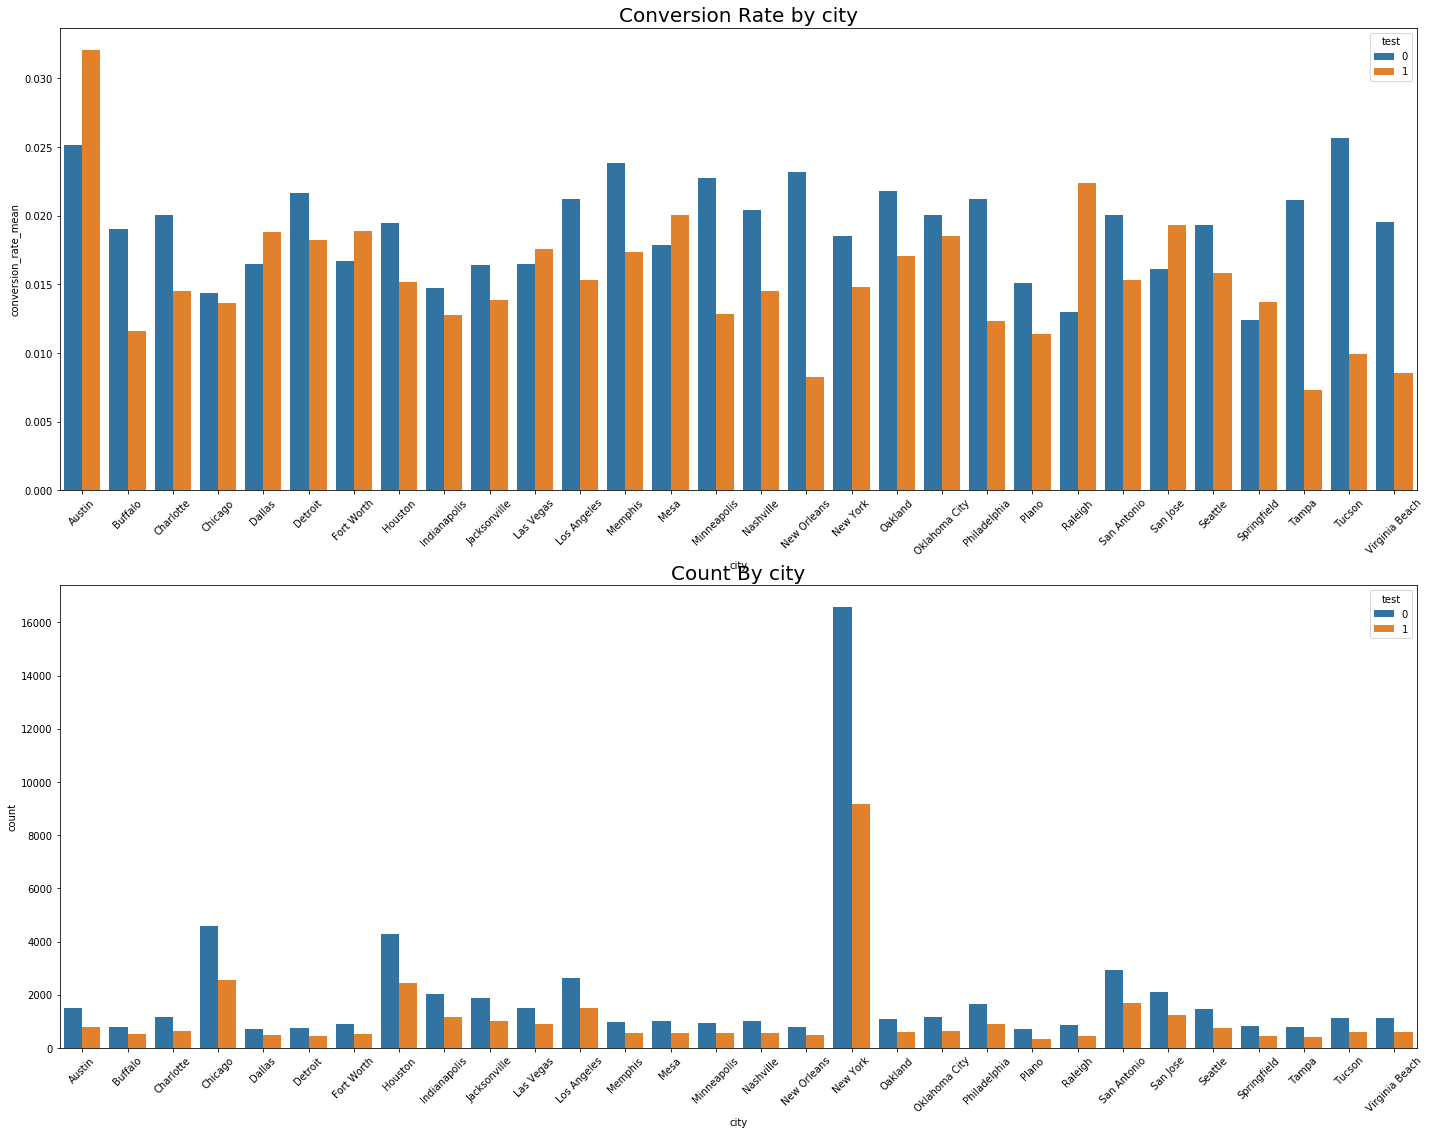

In [234]:
top_city = df_merge[['city','test','converted']].groupby('city').count().reset_index().sort_values(by=['converted'],ascending = False).head(30)
df_breakdown = df_merge[['city','test','converted']].merge(top_city['city'],on='city',how='inner')
df_breakdown = conversion_rate_breakdown_bytestctrol(df_breakdown)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
sns.barplot(x='city', y="conversion_rate_mean", hue='test', data=df_breakdown, ax=ax[0])
ax[0].set_title('Conversion Rate by city', fontsize=20)
#ax[0].set_yscale('log')
ax[0].set_xticklabels(labels=df_breakdown['city'].unique(), rotation=45)
plt.tight_layout()
############ conversion_rate, which one is higher bt control and exp group. They should follow the same trend

sns.barplot(x='city', y="count", hue='test', data=df_breakdown, ax=ax[1])
ax[1].set_title('Count By city', fontsize=20)
#ax[1].set_yscale('log')
ax[1].set_xticklabels(labels=df_breakdown['city'].unique(), rotation=45)
######## The percentage of each category should be the same between control and exp group

# 3. Analysis results of A/B Test


## 3.1 Conversion Rate -- Distribution

In [235]:
##split control group and test group
df_ctrl = df_test[df_test['test'] == 0]
df_exp = df_test[df_test['test'] == 1]

In [236]:
def expect_buyer_multiple(df, n):
    conversion_rates = []
    for i in range(0,n):
        df2 = df.sample(frac=0.1, replace=False)
        conversion_rate = df2['converted'].mean()
        conversion_rates.append(conversion_rate)
        
    return conversion_rates

exp_ctrl = expect_buyer_multiple(df_ctrl,1000)
exp_test = expect_buyer_multiple(df_exp,1000)

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text yticklabel objects>)

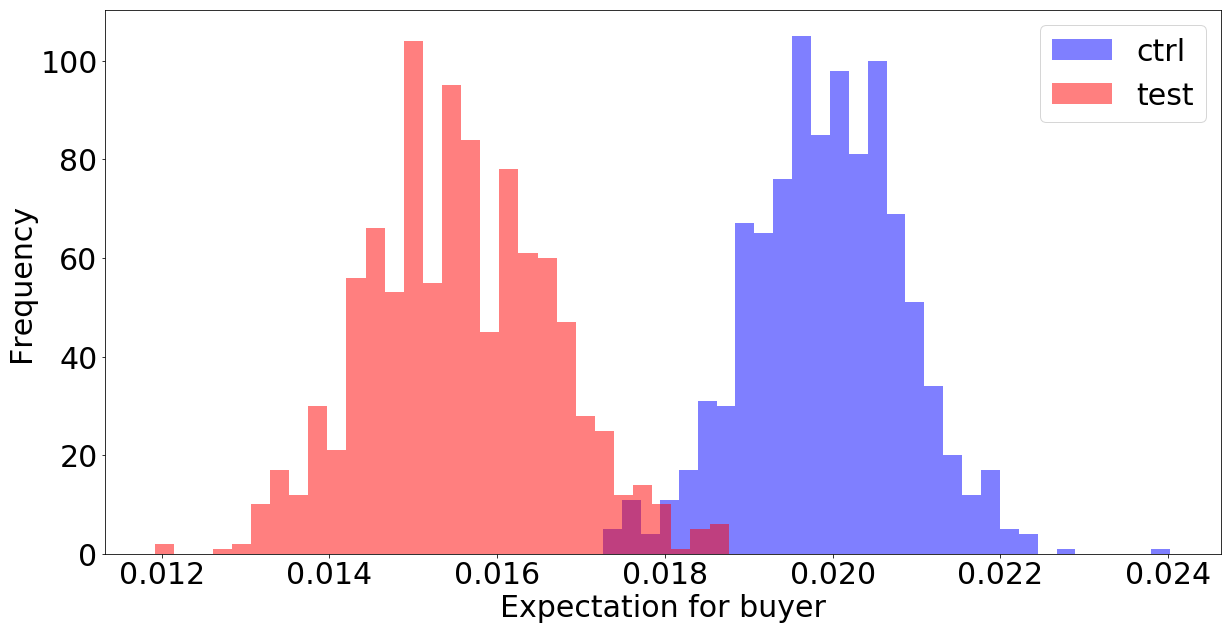

In [237]:
plt.figure(figsize=[20,10])
plt.hist(exp_ctrl,30, histtype='stepfilled', color='blue', alpha=0.50, label='ctrl')
plt.hist(exp_test,30, histtype='stepfilled', color='red', alpha=0.50, label='test')
plt.legend(loc='upper right', fontsize=30)
plt.xlabel('Expectation for buyer', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


## 2.2 Conversion rate --  Hypythesis Test signficance check

In [238]:
df_test[['test','converted']].groupby('test').mean()

,converted
test,
0,0.019904
1,0.015543


<font color='blue'>ctrol_mean is obviously bigger than test_mean, so I want to check if this is statistically significance (not caused by chance).

* Null hypothesis H0: experimental group's average conversion rate is bigger or same as control group's average conversion rate.

* Alternative hypothesis H1: experimental group's average conversion rate is smaller than control group's average conversion rate</font>


In [239]:
Ttest_indResult = stats.ttest_ind(df_ctrl['converted'], df_exp['converted'], axis=0, equal_var=True)

if Ttest_indResult.pvalue/2 > 0.05:
  print("fail to reject null H0")
elif Ttest_indResult.pvalue/2 <= 0.05:
  print("reject H0")

reject H0


<font color='blue'> **According to the test, the conversion rate of users with higher price is smaller than the cheaper price group**</font>

## 2.3 Revenue -- Distribution

In [240]:
df_test['revenue'] = df_test['converted'] * df_test['price']

In [241]:
df_ctrol_revenue = df_test[df_test['test'] == 0]
df_exp_revenue = df_test[df_test['test'] == 1]

In [242]:

def expect_buyer_multiple(df, n):
    exp=np.empty(n)
    for i in range(0,n):
        df2 = df.sample(frac=0.1, replace=False)
        p = df2['converted'].mean()
        exp[i] = p
        
    return exp

exp_ctrl = expect_buyer_multiple(df_ctrol_revenue,1000)
exp_test = expect_buyer_multiple(df_exp_revenue,1000)

Text(0.5, 1.0, 'Avg Revenue Distribution')

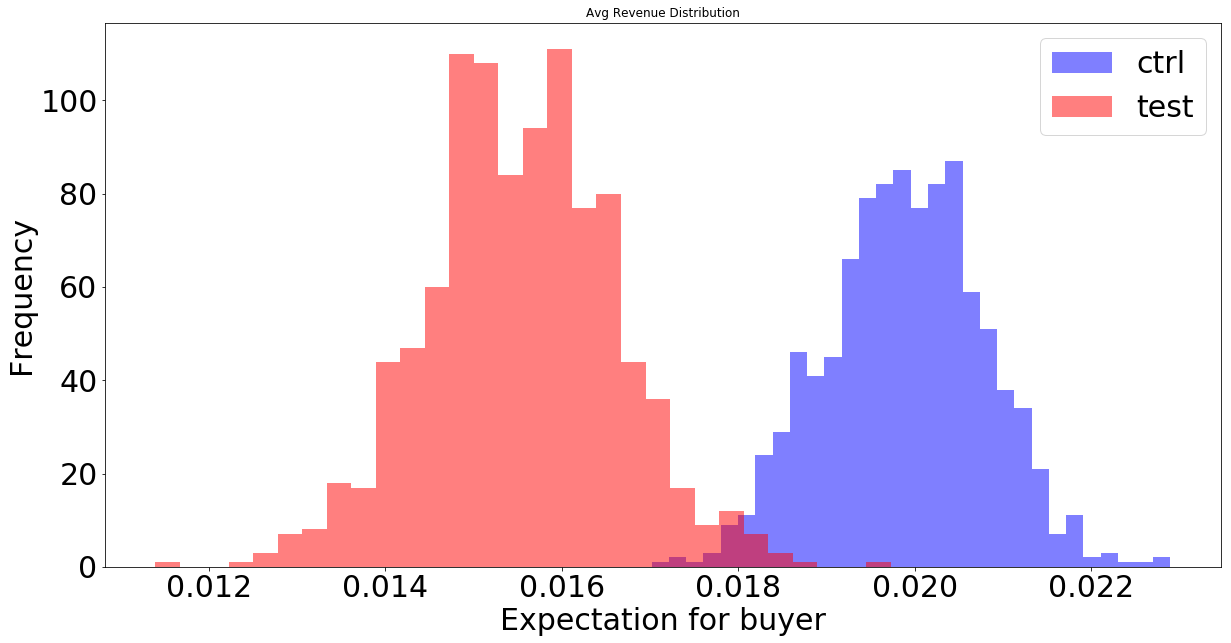

In [243]:
plt.figure(figsize=[20,10])
plt.hist(exp_ctrl,30, histtype='stepfilled', color='blue', alpha=0.50, label='ctrl')
plt.hist(exp_test,30, histtype='stepfilled', color='red', alpha=0.50, label='test')
plt.legend(loc='upper right', fontsize=30)
plt.xlabel('Expectation for buyer', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Avg Revenue Distribution')


## 2.4 Revenue --  Hypothesis Test significance check

In [43]:
df_test[['test','revenue']].groupby('test').mean()

,revenue
test,
0,0.776734
1,0.916843


<font color='blue'>The avg revenue of the test group is obviously bigger than control group. Now we need to find if it is not by chance.
* H0: Avg revenue of the test group is smaller or the same as control group
* H1: Avg revenue of the test group is bigger than control group</font>

In [48]:
Ttest_indResult = stats.ttest_ind(df_exp_revenue['revenue'], df_ctrol_revenue['revenue'], axis=0, equal_var=True)

if Ttest_indResult.pvalue/2 > 0.05:
  print("fail to reject null H0")
elif Ttest_indResult.pvalue/2 <= 0.05:
  print("reject H0")

reject H0


<font color='blue'>**According to the test, avg revenue of users with higher price is bigger than users with lower price.**</font>

<font color='blue'>**In summary, although raising the price will hurt the conversion rate, but the general revenue level will increase. So we should sell the software for $59 to gain more revenue**

# 3. Machine Learning 

<font color='blue'>I plan to use Random Forest to detect variable importance. Dependent variable will be converted. let's check if converted is spread evenly

In [54]:
data.groupby('converted').count()

,user_id,timestamp,source,device,operative_system,test,price,city,country,lat,long
converted,,,,,,,,,,,
0,270597,270597,270597,270597,270597,270597,270597,270597,270597,270597,270597
1,5019,5019,5019,5019,5019,5019,5019,5019,5019,5019,5019


<font color='blue'>It seems like converted has lots of 0, which will cause prediction trouble when we run machine learning

In [196]:
data = df_user.merge(df_test,on='user_id',how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 0 to 275615
Data columns (total 13 columns):
user_id             275616 non-null object
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
timestamp           275616 non-null object
source              275616 non-null object
device              275616 non-null object
operative_system    275616 non-null object
test                275616 non-null int64
price               275616 non-null int64
converted           275616 non-null int64
revenue             275616 non-null int64
dtypes: float64(2), int64(4), object(7)
memory usage: 29.4+ MB


In [197]:
data.groupby('converted').count()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,revenue
converted,,,,,,,,,,,,
0,270597,270597,270597,270597,270597,270597,270597,270597,270597,270597,270597,270597
1,5019,5019,5019,5019,5019,5019,5019,5019,5019,5019,5019,5019


In [198]:
zero = data[data['converted'] == 0]
one = data[data['converted'] == 1]

In [199]:
one = one.sample(n=10000, replace=True,random_state=1)
zero = zero.sample(n=10000, replace=True,random_state=1)
data = one.append(zero)
data.shape

(20000, 13)

In [118]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 0 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_laura_liu_yi9609
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.209 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [200]:
import datetime
data['month'] = data.apply(lambda x: datetime.datetime.strptime(x['timestamp'].replace('60','59'), "%Y-%m-%d %H:%M:%S").strftime("%b"), axis=1)
data['day'] = data.apply(lambda x: datetime.datetime.strptime(x['timestamp'].replace('60','59'), "%Y-%m-%d %H:%M:%S").day, axis=1)
data['hour'] = data.apply(lambda x: datetime.datetime.strptime(x['timestamp'].replace('60','59'), "%Y-%m-%d %H:%M:%S").hour, axis=1)
del data['timestamp']

In [201]:
data.head()

,user_id,city,country,lat,long,source,device,operative_system,test,price,converted,revenue,month,day,hour
13033,90320,Memphis,USA,35.11,-90.01,friend_referral,web,windows,1,59,1,59,May,22,21
219825,925658,Philadelphia,USA,40.01,-75.13,direct_traffic,mobile,iOS,0,39,1,39,Mar,25,16
50110,426057,Bremerton,USA,47.55,-122.70,ads_facebook,mobile,android,0,39,1,39,Mar,14,8
153398,679312,Marshfield,USA,42.09,-70.71,ads_facebook,web,windows,0,39,1,39,Apr,28,11
160676,605660,Tampa,USA,27.96,-82.48,direct_traffic,mobile,other,0,39,1,39,Mar,6,7


In [202]:
data = data[['source','device','operative_system','test','converted','city','country','lat','long','hour','day','month']]


In [203]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['test'] = h2o_df['test'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()
#h2oh2o_df['month'].asfactor()
#h2o_df['hour'] = h2o_df['hour'].asfactor()
#h2o_df['day'] = h2o_df['day'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,source,device,operative_system,test,converted,city,country,lat,long,hour,day,month
type,enum,enum,enum,enum,enum,enum,enum,real,real,int,int,enum
mins,,,,,,,,19.7,-157.8,0.0,1.0,
mean,,,,,,,,37.03392099999985,-93.98783550000016,11.936999999999998,15.905650000000037,
maxs,,,,,,,,61.18,30.31,23.0,31.0,
sigma,,,,,,,,5.246030679252021,18.14024051346157,5.051772661190424,8.77528337761338,
zeros,,,,,,,,0,0,340,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,friend_referral,web,windows,1,1,Memphis,USA,35.11,-90.01,21.0,22.0,May
1,direct_traffic,mobile,iOS,0,1,Philadelphia,USA,40.01,-75.13,16.0,25.0,Mar
2,ads_facebook,mobile,android,0,1,Bremerton,USA,47.55,-122.7,8.0,14.0,Mar


In [206]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['source','device','operative_system','test','city','country','lat','long','hour','day','month']

target = 'converted'

In [207]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=1000, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

C:\Users\laura.liu\Anaconda3\lib\site-packages\h2o\estimators\estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [country]
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |███████████████████████████████████████████████| 100%


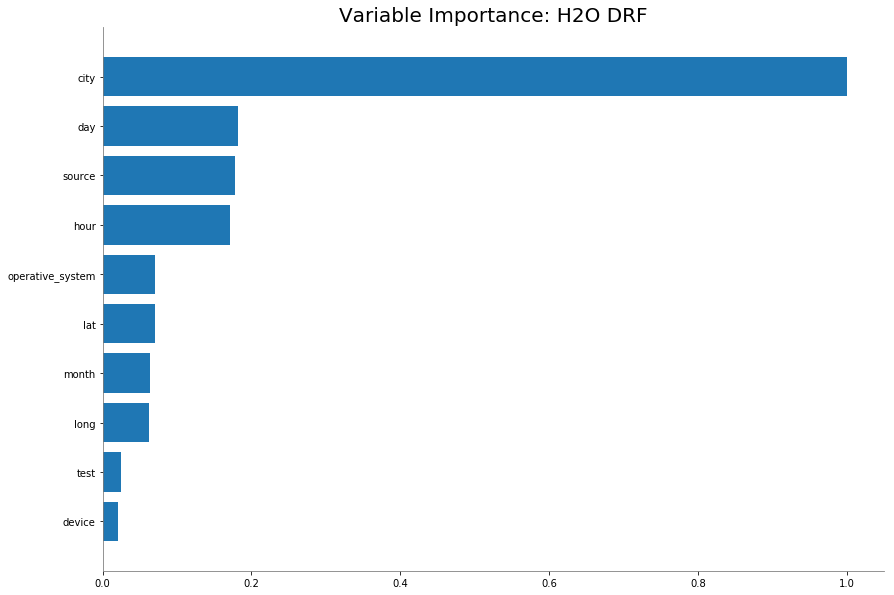

In [208]:
model.varimp_plot()


In [209]:
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [210]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2500
           1       0.78      0.85      0.81      2500

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



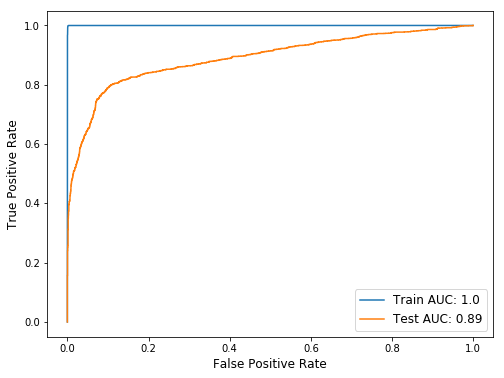

In [211]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### Looking into City

In [306]:
city_count = df_merge.groupby('city').count()['user_id'].reset_index().sort_values(by=['user_id'],ascending=False).head(50)
city_ctrol_cr = df_merge[df_merge['test'] == 0][['city','converted']].groupby('city').mean().reset_index()
city_count = city_count.merge(city_ctrol_cr,on='city',how='left').rename(columns={"converted": "ctrol_cr"})
city_exp_cr = df_merge[df_merge['test'] == 1][['city','converted']].groupby('city').mean().reset_index()
city_count = city_count.merge(city_exp_cr,on='city',how='left').rename(columns={"converted": "exp_cr","user_id":"#user"})
city_count['diff'] =  city_count['exp_cr'] - city_count['ctrol_cr']

In [308]:
city_count.head()

,city,#user,ctrol_cr,exp_cr,diff
0,New York,25748,0.018525,0.014821,-0.003704
1,Chicago,7153,0.014367,0.013677,-0.000689
2,Houston,6706,0.019461,0.015158,-0.004303
3,San Antonio,4633,0.020082,0.015339,-0.004742
4,Los Angeles,4141,0.021220,0.015313,-0.005907


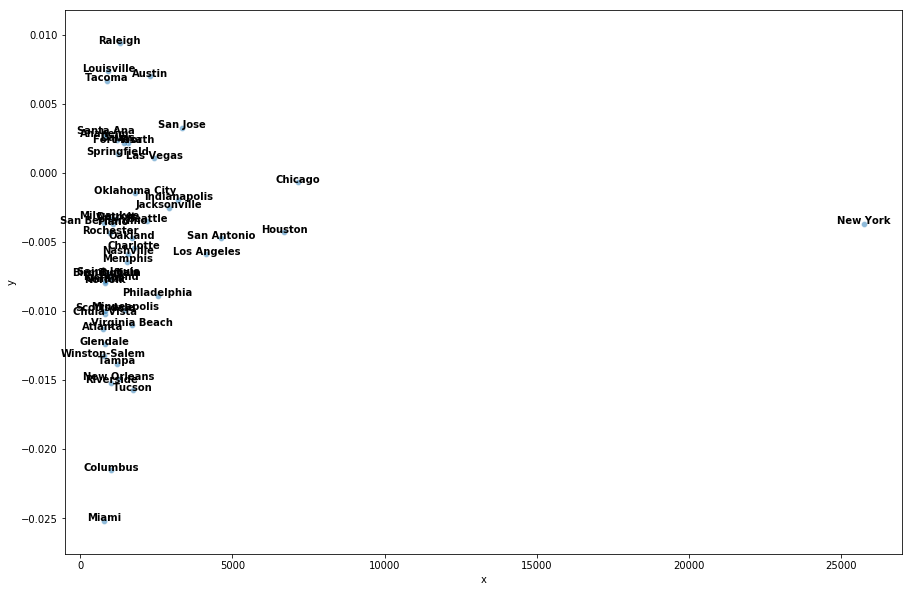

In [307]:
df = pd.DataFrame({
'x': city_count['#user'],
'y': city_count['diff'],
'group': city_count['city']
})



#Create figure
plt.figure(figsize = (15,10))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(df.x, df.y, alpha = 0.5)


#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     ax.text(df.x[line], df.y[line], df.group[line], horizontalalignment='center', size='medium', color='black', weight='semibold')


(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text yticklabel objects>)

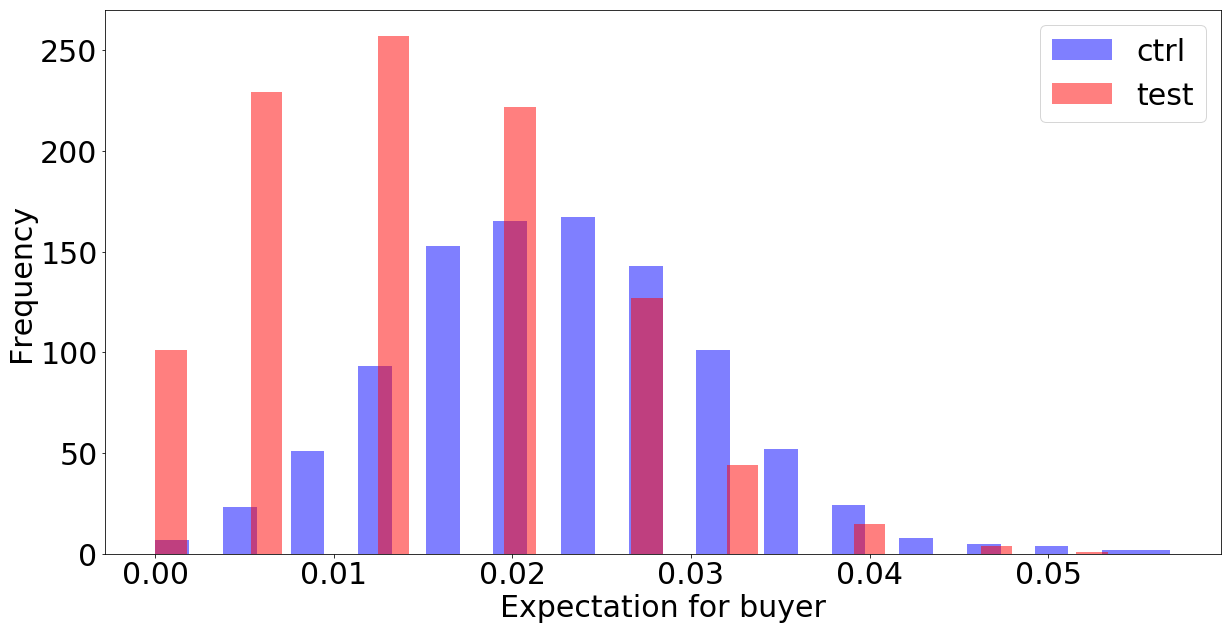

In [358]:
df_merge_city = df_merge[df_merge['city'] == 'Los Angeles' ]
df_merge_city = df_merge_city[df_merge_city.city.notnull()]
##split control group and test group
df_ctrl = df_merge_city[df_merge_city['test'] == 0]
df_exp = df_merge_city[df_merge_city['test'] == 1]

def expect_buyer_multiple(df, n):
    conversion_rates = []
    for i in range(0,n):
        df2 = df.sample(frac=0.1, replace=False)
        conversion_rate = df2['converted'].mean()
        conversion_rates.append(conversion_rate)
        
    return conversion_rates

exp_ctrl = expect_buyer_multiple(df_ctrl,1000)
exp_test = expect_buyer_multiple(df_exp,1000)


plt.figure(figsize=[20,10])
plt.hist(exp_ctrl,30, histtype='stepfilled', color='blue', alpha=0.50, label='ctrl')
plt.hist(exp_test,30, histtype='stepfilled', color='red', alpha=0.50, label='test')
plt.legend(loc='upper right', fontsize=30)
plt.xlabel('Expectation for buyer', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


In [359]:
Ttest_indResult = stats.ttest_ind(df_ctrl['converted'], df_exp['converted'], axis=0, equal_var=True)

if Ttest_indResult.pvalue/2 > 0.05:
  print("fail to reject null H0")
elif Ttest_indResult.pvalue/2 <= 0.05:
  print("reject H0")

fail to reject null H0


In [344]:
p_values = []
Test_results = []
for city_name in city_count['city'].tolist():
    df_merge_city = df_merge[df_merge['city'] == city_name]
    ##split control group and test group
    df_ctrl = df_merge_city[df_merge_city['test'] == 0]
    df_exp = df_merge_city[df_merge_city['test'] == 1]
    Ttest_indResult = stats.ttest_ind(df_ctrl['converted'], df_exp['converted'], axis=0, equal_var=True)
    p_value = Ttest_indResult.pvalue/2
    p_values.append(p_value)
    if p_value > 0.05:
        Test_result = 'fail to reject H0'
    elif p_value<= 0.05:
        Test_result = 'reject H0'
    Test_results.append(Test_result)
    

In [346]:
city_count['p_value'] = p_values
city_count['test_result'] = Test_results
city_count

,city,#user,ctrol_cr,exp_cr,diff,p_value,test_result
0,New York,25748,0.018525,0.014821,-0.003704,0.014299,reject H0
1,Chicago,7153,0.014367,0.013677,-0.000689,0.406398,fail to reject H0
2,Houston,6706,0.019461,0.015158,-0.004303,0.100490,fail to reject H0
3,San Antonio,4633,0.020082,0.015339,-0.004742,0.123361,fail to reject H0
4,Los Angeles,4141,0.021220,0.015313,-0.005907,0.090816,fail to reject H0
5,San Jose,3354,0.016083,0.019355,0.003272,0.241535,fail to reject H0
6,Indianapolis,3217,0.014706,0.012744,-0.001962,0.324141,fail to reject H0
7,Jacksonville,2905,0.016376,0.013834,-0.002542,0.298608,fail to reject H0
8,Philadelphia,2541,0.021238,0.012318,-0.008920,0.053731,fail to reject H0
9,Las Vegas,2426,0.016513,0.017544,0.001031,0.424348,fail to reject H0
